### Autoencoder with Convolutional Neural Network

In this notebook, I will experiment with the implementation of an autoencoder for augmentation of the histopathology dataset. The augmented data is used to train a CNN network to see if it performs better than a baseline CNN model trained on the normal dataset. First, the required libraries are imported and the size of the images in the PCAM dataset is defined.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, MaxPool2D, UpSampling2D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Instantiating data generators

The PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within the function `get_pcam_generators` that returns them as output arguments. This function will later be called from the main code body. The class `model_transform` is used to set the correct preprocessing function for the data generators.


In [2]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32, class_mode='binary', prep_function=None):
     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255

     # instantiate data generators
     if prep_function is None:
          datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)
     else:
          datagen = ImageDataGenerator(rescale=RESCALING_FACTOR, preprocessing_function=prep_function)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode=class_mode)


     val_gen = datagen.flow_from_directory(VALID_PATH,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size=val_batch_size,
                                           class_mode=class_mode,
                                           shuffle=False)
     
     return train_gen, val_gen

Now, the function `get_pcam_generators` that defines the data generators can be called from the main code body. Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [3]:
train_gen, val_gen = get_pcam_generators('../data')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Building model architectures

The model architectures are defined within a class. Organizing the code into classes instead of piling everything up in a single script makes the code more clear to read and understand, and helps reuse functionality that is already implemented. For example, we can use the `get_pcam_generators` function to create data generators with different batch sizes just by calling the function with a different set of parameters. Or, we can use the `model_architecture` class to generate networks with different number of feature maps (see below). 

In [4]:
# Class structure from Constantijn & Nino implemented for AE model from Mart
class model_architecture(Sequential):
    def __init__(self, kernel_size, pool_size, first_filters, second_filters):
        super().__init__()
        self.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.first_filters = first_filters
        self.second_filters = second_filters

    def create_cnn(self):
        self.add(Conv2D(self.first_filters, self.kernel_size, activation='relu', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
        self.add(MaxPool2D(pool_size=self.pool_size))
        self.add(Conv2D(self.second_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(MaxPool2D(pool_size=self.pool_size))

        # layers replacing the dense layers
        self.add(Conv2D(self.second_filters, (6,6), activation='relu', padding='valid'))
        self.add(Conv2D(1, (1,1), activation='sigmoid', padding='same'))
        self.add(GlobalAveragePooling2D())

    def compile_cnn(self):
        self.compile(SGD(learning_rate=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

    def create_autoencoder(self):
        # Encoder
        self.add(Conv2D(self.first_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(MaxPool2D(self.pool_size, padding='same'))
        self.add(Conv2D(self.second_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(MaxPool2D(self.pool_size, padding='same'))

        # Decoder
        self.add(Conv2D(self.second_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(UpSampling2D(self.pool_size))
        self.add(Conv2D(self.first_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(UpSampling2D(self.pool_size))
        self.add(Conv2D(3, self.kernel_size, activation='sigmoid', padding='same'))

    def compile_autoencoder(self):
        self.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
        

### Training the CNN model on regular data and evaluating the model

In the next part, an instance of the `model_architecture` class is created for the CNN model. A kernel size of (3,3) and a pooling size of (4,4) is used. After that, the training phase will be initiated. This is followed by a ROC curve analysis of the trained CNN model. The training is done with the regular dataset.

In [5]:
model_cnn = model_architecture(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn.create_cnn()
model_cnn.compile_cnn()
model_cnn._name = 'cnn'

model_cnn.summary();

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)          147520    
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 1)           65      

In [6]:
# Save the model and weights
model_name = 'cnn'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model_cnn.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)

# Define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model_cnn.fit(train_gen, steps_per_epoch=train_steps,
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=1,
                        callbacks=callbacks_list)

4500/4500 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.7596
Epoch 1: val_loss improved from inf to 0.44511, saving model to cnn_weights.hdf5
4500/4500 [==============================] - 1271s 282ms/step - loss: 0.4900 - accuracy: 0.7596 - val_loss: 0.4451 - val_accuracy: 0.7994


c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 29s 58ms/step


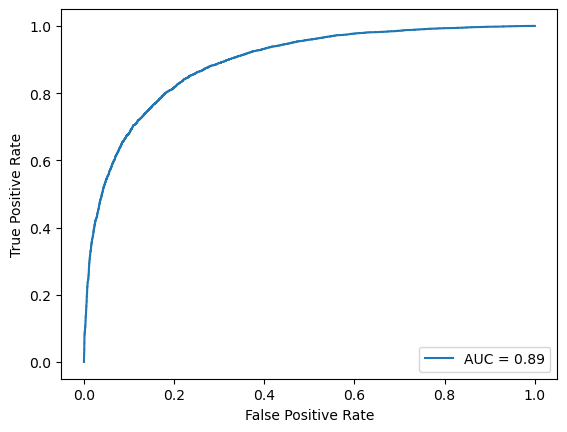

In [7]:
# Getting labels and predictions on validation set
val_true = val_gen.classes
val_probs = model_cnn.predict(val_gen, steps=val_steps)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot();

### Training and evaluating the autoencoder model

First, we need to construct new data generators. The training process of the autoencoder is unsupervised so the class mode of the data generators should be set to `input`. With these new generators, the autoencoder can be trained effectively. A new instance of the `model_architecture` class is created for the autoencoder. 

In [8]:
# Constructing the data generators for unsupervised learning for autoencoder training
train_gen_ae, val_gen_ae = get_pcam_generators('../data', class_mode='input') 

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [9]:
model_ae = model_architecture(kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16)
model_ae.create_autoencoder()
model_ae.compile_autoencoder()
model_ae._name = 'Autoencoder'

model_ae.summary();

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 up_sampling2d (UpSampling2  (None, 48, 48, 16)        

Next, the training phase of the autoencoder can be initiated.

In [10]:
# Save the model and weights
model_name = 'autoencoder'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model_ae.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps_ae = train_gen_ae.n//train_gen_ae.batch_size
val_steps_ae = val_gen_ae.n//val_gen_ae.batch_size

history = model_ae.fit(train_gen_ae, steps_per_epoch=train_steps_ae, 
                       validation_data=val_gen_ae,
                       validation_steps=val_steps_ae,
                       epochs=3,
                       callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.0132
Epoch 1: val_loss improved from inf to 0.01070, saving model to autoencoder_weights.hdf5
4500/4500 [==============================] - 2259s 502ms/step - loss: 0.0132 - val_loss: 0.0107
Epoch 2/3


c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4500/4500 [==============================] - ETA: 0s - loss: 0.0100
Epoch 2: val_loss improved from 0.01070 to 0.00949, saving model to autoencoder_weights.hdf5
4500/4500 [==============================] - 2095s 466ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.0092
Epoch 3: val_loss improved from 0.00949 to 0.00904, saving model to autoencoder_weights.hdf5
4500/4500 [==============================] - 2303s 512ms/step - loss: 0.0092 - val_loss: 0.0090


Lets visualize the output of the trained CAE model. The output of the CAE model is used as augmented dataset in the upcoming steps.

1/1 [==============================] - 0s 210ms/step


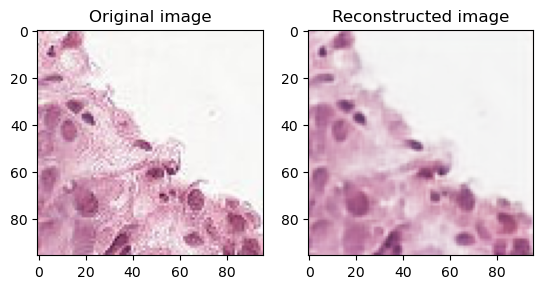

In [11]:
# Produce a prediction on the validation set
img_batch = train_gen_ae[0][1] # [batch][class][image_nr]
predict_test = model_ae.predict(img_batch) 
image_nr = 3

fig,ax = plt.subplots(1,2)
ax[0].imshow(img_batch[image_nr])
ax[0].set_title('Original image')
ax[1].imshow(predict_test[image_nr])
ax[1].set_title('Reconstructed image');

### Training CNN with CAE preprocessing function

The generators for the augmented data are initialized with the CAE model as preprocessing function. This is done by defining a new funtion `model_transform` that is responsible for augmenting the input of the data generators. The `model_architecture` class is used again to create a new instance for this model. This model is trained on the augmented dataset.

In [12]:
# Written by Constantijn
class model_transform:
     def __init__(self, ae_model_1):
          self.ae_model_1 = ae_model_1

     def model_transform(self, tensor):
          tensor_adjusted = utils.img_to_array(tensor)
          tensor_adjusted = np.array([tensor_adjusted])
          tensor_adjusted_prediction = self.ae_model_1.predict(tensor_adjusted/255, verbose=None)[0]
          return tensor_adjusted_prediction*255

In [13]:
# Constructing the data generators for the augmented dataset  
train_gen_aug, val_gen_aug = get_pcam_generators('../data',
                                                 class_mode='binary', 
                                                 prep_function=model_transform(model_ae).model_transform)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


The following code is to see if the generator works properly. It plots a few images of a batch to see the result.

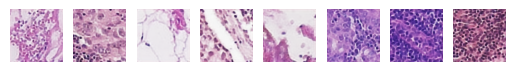

In [14]:
fig,ax = plt.subplots(1, 8)
for images, labels in train_gen_aug:
    for i in range(8):
        ax[i].imshow(images[i])
        ax[i].axis('off')
    break

In [15]:
model_cnn_aug = model_architecture(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn_aug.create_cnn()
model_cnn_aug.compile_cnn()
model_cnn_aug._name = 'cnn_aug'

model_cnn_aug.summary()

Model: "cnn_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 64)          147520    
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 1, 1)           65  

The training phase can now be initiated.

In [16]:
# Save the model and weights
model_name = 'cnn_aug'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model_cnn_aug.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)

# Define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps_cnn_aug = train_gen_aug.n//train_gen_aug.batch_size
val_steps_cnn_aug = val_gen_aug.n//val_gen_aug.batch_size

history = model_cnn_aug.fit(train_gen_aug, steps_per_epoch=train_steps_cnn_aug,
                            validation_data=val_gen_aug,
                            validation_steps=val_steps_cnn_aug,
                            epochs=1,
                            callbacks=callbacks_list)

2355/4500 [==============>...............] - ETA: 3:38:11 - loss: 0.4985 - accuracy: 0.7568

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/cnn_aug/max_pooling2d_4/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "c:\Users\20212077\.conda\envs\8p361\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\20212077\.conda\envs\8p361\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\20212077\.conda\envs\8p361\lib\asyncio\windows_events.py", line 316, in run_forever
      super().run_forever()
    File "c:\Users\20212077\.conda\envs\8p361\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\20212077\.conda\envs\8p361\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\20212077\.conda\envs\8p361\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\20212077\AppData\Local\Temp\ipykernel_23712\4094819189.py", line 19, in <module>
      history = model_cnn_aug.fit(train_gen_aug, steps_per_epoch=train_steps_cnn_aug,
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\optimizers\optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\optimizers\optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/cnn_aug/max_pooling2d_4/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[32,96,96,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/cnn_aug/max_pooling2d_4/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_100070]

In [17]:
# Getting labels and predictions on validation set
val_true = val_gen_aug.classes
val_probs = model_cnn_aug.predict(val_gen_aug, steps=val_steps_cnn_aug)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot()

  5/500 [..............................] - ETA: 1:29:32

: 